<h1 style="text-align: center;">Analyis of Point Production of NBA Players</h1>

# Introduction

Using this dataset of NBA player stats we want to perform a regression analysis of the selected variables to help predict the on-court performance of a player (their average points scored). To do so, all other numerical values of influence (Rebounds, Assists, Usage Percentage, etc) will be used. All of these factors were selected because of their likelihood to correlate with stronger on-court performance, for example, a higher true shooting efficiency, or the percentage of shots from all parts of the court that go in, will be a strong predictor for points per game as it correlates with a better on court performance.

Our question: How do our selected factors help to predict the individual average points per game scored of NBA players? 

To do this, we will use [this dataset](https://www.kaggle.com/datasets/justinas/nba-players-data) from Kaggle. The data was acquired through the NBA API with missing information supplied by scraping from another NBA source (for this reason, the dataset was taken directly from Kaggle and not the original source). 

# Methods and Results

## Load Libraries

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.4     ✔ rsample      1.1.1
✔ dials        1.2.0     ✔ tune         1.1.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.0     ✔ yardstick    1.1.0
✔ recipes      1.0.5     

── Conflicts ──────────────────────

## Dataset Load & Preperation

The dataset contains 22 variables, the majority of which we discard as categorical variables cannot be used and several numeric variables dont provide a predictive relationship to points per game score. We will conduct analysis on the remaining selected variables to try and predict the average points a player will get per season using regression analysis. By first training a model on the training data for each respective datapoint category we will then be able too use the k-nearest neighbors algorithm to perform regression on the data and decide which of the columns provides the best predictor for a players preformance.

First we pull our dataset from the internet.

In [44]:
url <-"https://raw.githubusercontent.com/mdean808/dsci-100-group-project/b11c50b091b2c4a554a2b7ff8f9e568e081b0f3c/all_seasons.csv"

temp <- tempfile()

download.file(url, temp)
# read the dataset from temp file
player_data <- read_csv(temp)
head(player_data)

New names:
• `` -> `...1`
Rows: 12305 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): player_name, team_abbreviation, college, country, draft_year, draf...
dbl (14): ...1, age, player_height, player_weight, gp, pts, reb, ast, net_ra...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,⋯,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,Dennis Rodman,CHI,36,198.12,99.79024,Southeastern Oklahoma State,USA,1986,2,⋯,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,1996-97
1,Dwayne Schintzius,LAC,28,215.90,117.93392,Florida,USA,1990,1,⋯,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,1996-97
2,Earl Cureton,TOR,39,205.74,95.25432,Detroit Mercy,USA,1979,3,⋯,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,1996-97
3,Ed O'Bannon,DAL,24,203.20,100.69742,UCLA,USA,1995,1,⋯,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,1996-97
4,Ed Pinckney,MIA,34,205.74,108.86208,Villanova,USA,1985,1,⋯,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,1996-97
5,Eddie Johnson,HOU,38,200.66,97.52228,Illinois,USA,1981,2,⋯,8.2,2.7,1.0,4.1,0.034,0.126,0.220,0.541,0.102,1996-97


For our project, we will focus only on the specific parameters to predict the Points Per Game (pts) of an NBA player. Our chosen variables are; rebounds (reb), and assists (ast), usage percentage (usg_pct), true shooting percentage (ts_pct), and their draft number (draft_number).

Below are descriptions for each variable and a short explanation as to why they matter:

reb - Rebounds, rebounds measure the amount of times a player gets the ball after it hits either backboard, rebounds are an offensive and defesnive statistic. The more rebounds a player grabs indicates he spends time around the rim, the easiest place to score the ball, however rebounds are easier for players who play the foward or center positions to obtain and dont account for guards who are able to score without playing around the rim.

ast - Assists, assists measure the amount of times a player passes the ball to his teammate that subsequently scores. Better players with a higher "gravity" attract more defenders opening opportunities for their teammates to score when the ball is passed from a high scoring player.

usg_pct - Usage Percentage, usage measures the percentage of the game a player has the ball in possesion, players more likely to score the ball are often the ones who have the ball the most often, as coaches want their best players to have the most chances to score, serving as a strong predictive metric

ts_pct - True Shooting Percentage, True shooting (TS) measures the percent efficiency at which a players shots are made, a player with a TS percentage of 90 scores 90 percent of their shots, meaning higher percents could be a good indicator of points per game. However many players who dont often shoot the ball might have inflated percentages due to their lack of attempts. We attempted to filter this by making our data set only include players who played at least a quarter of the season, but bench players or non-offensive oriented players may still create outliers in the data.

draft_number - Draft Number, better prospects are drafted higher in the draft, meaning they're considered to be more likely to have good careers and contribute to winnings. Therefore, lower draft numbers should indicate higher preformance and thus points per game.

Additionally, players drafted in or before 2011 are excluded, to keep the data used recent and the dataset size managable.
In order to remove outliers that skew our data set due to them not playing enough, a minimum of 21 games, a quarter of the NBA season, is required for a player to be taken into consideration.

In [19]:
nba_players <- player_data |>
    filter(draft_year > 2011) |>
    filter(gp > 20) |>
    select(pts, reb, ast, usg_pct, ts_pct, draft_number) |>
    # remove undrafted players with no draft number "Undrafted"
    filter(draft_number != "Undrafted") |>
    mutate(draft_number = as.numeric(draft_number))            
nba_players

pts,reb,ast,usg_pct,ts_pct,draft_number
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2.3,1.6,0.3,0.198,0.417,28
4.0,2.7,0.4,0.146,0.632,37
1.3,1.1,0.2,0.134,0.407,60
⋮,⋮,⋮,⋮,⋮,⋮
11.3,7.0,0.8,0.191,0.551,2
4.5,3.0,0.5,0.205,0.518,8
12.1,3.8,5.9,0.179,0.540,6


Now we will split the data into training and testing. We will use the training data to build our regression model and our testing data to measure how well our model performs.

In [20]:
set.seed("1234")
nba_players_split <- initial_split(nba_players, prop = 0.75, strata = pts)
nba_training <- training(nba_players_split)
nba_testing <- testing(nba_players_split)

nba_training

pts,reb,ast,usg_pct,ts_pct,draft_number
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4.0,2.7,0.4,0.146,0.632,37
4.0,2.0,0.8,0.203,0.437,40
2.6,0.8,1.2,0.213,0.461,25
⋮,⋮,⋮,⋮,⋮,⋮
27.1,13.8,7.9,0.309,0.661,41
13.8,3.4,2.9,0.195,0.597,11
28.4,9.1,8.7,0.368,0.571,3


# Dataset Visualization

Now we will look at the correlation of multiple parameters compared with points. This will allow us to predict which parameters strongly influence overall points scored before we build our regression model. 

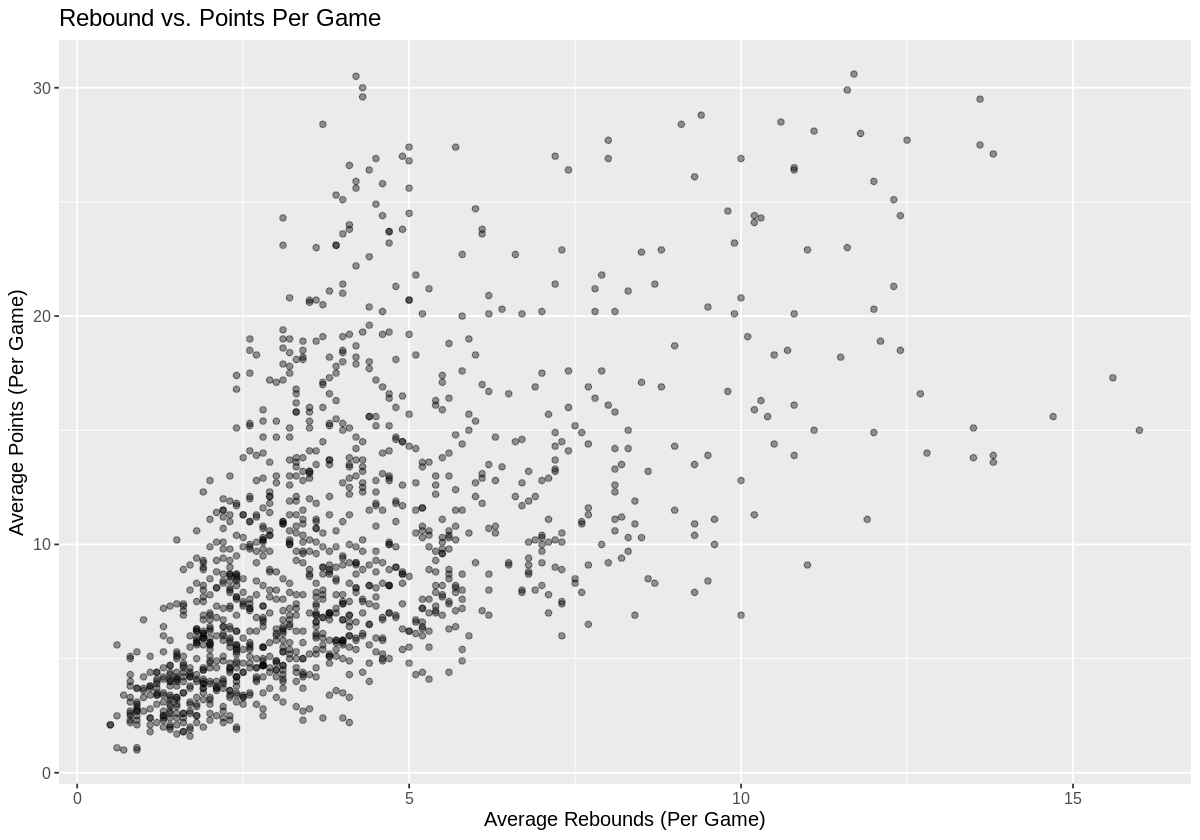

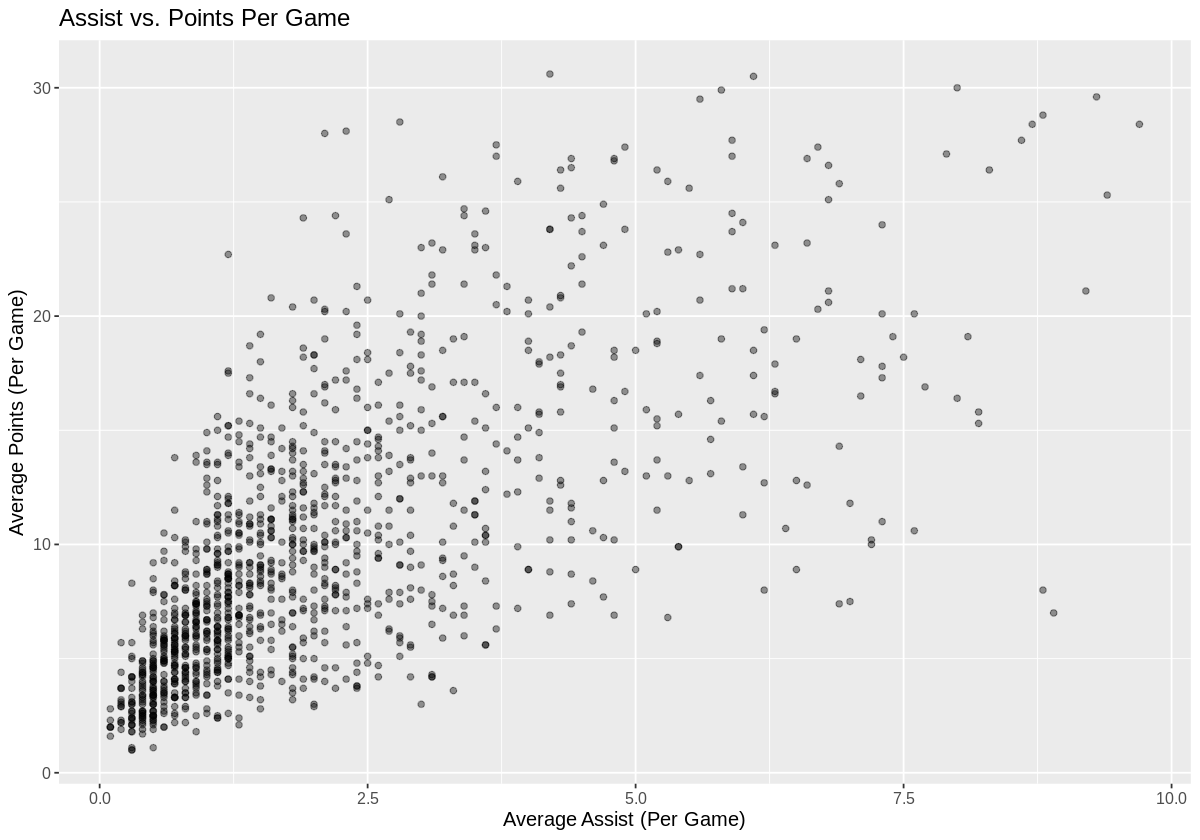

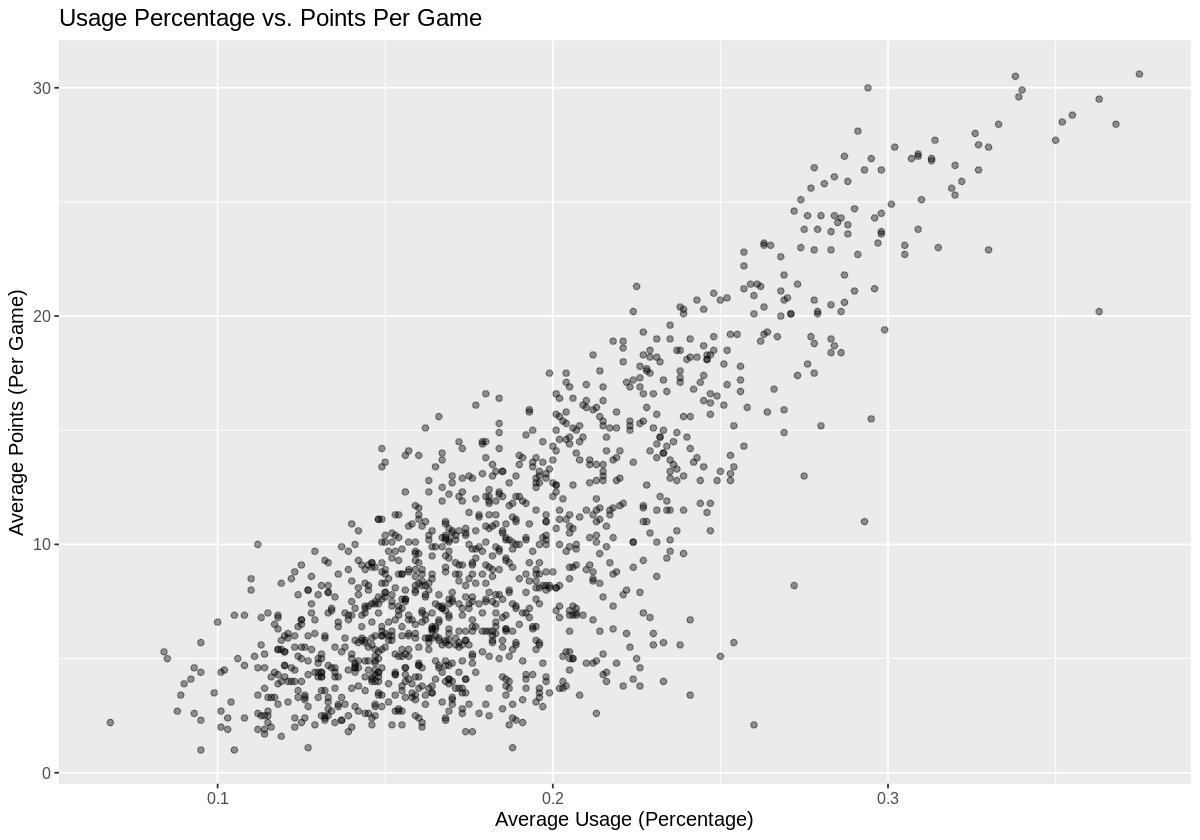

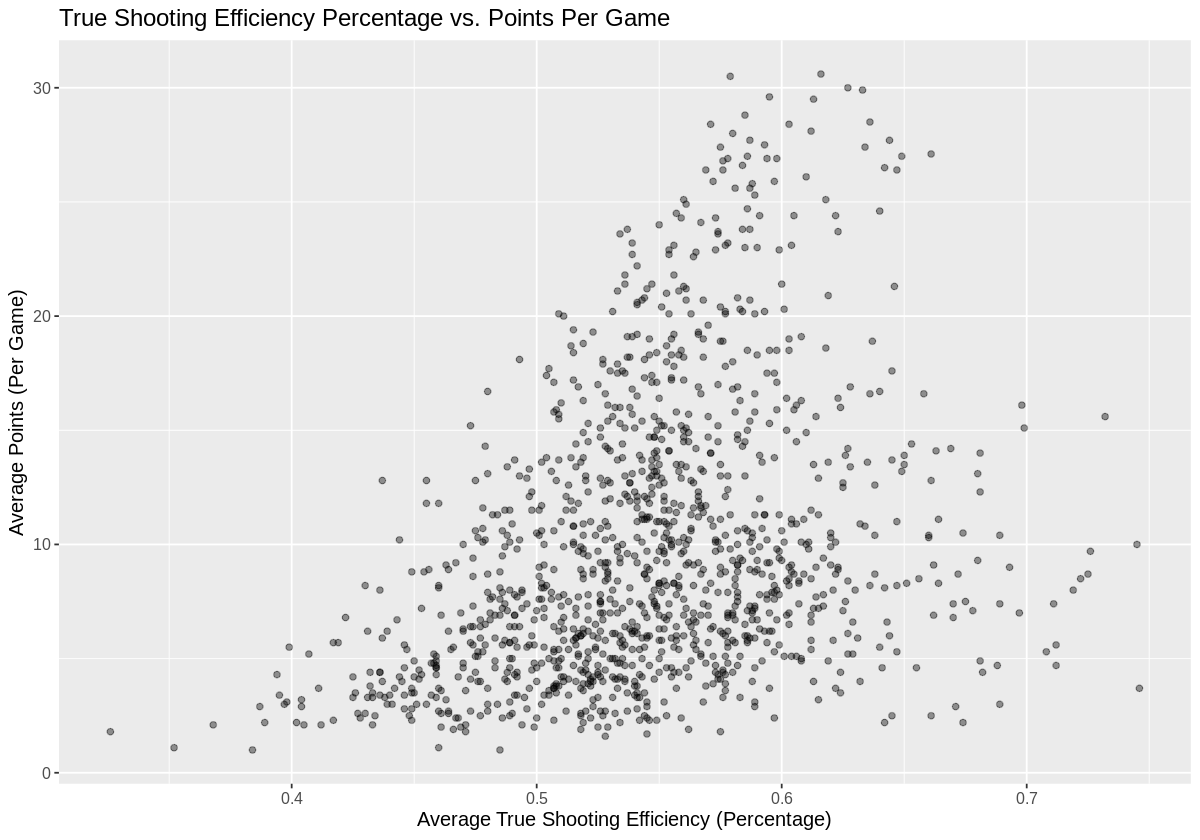

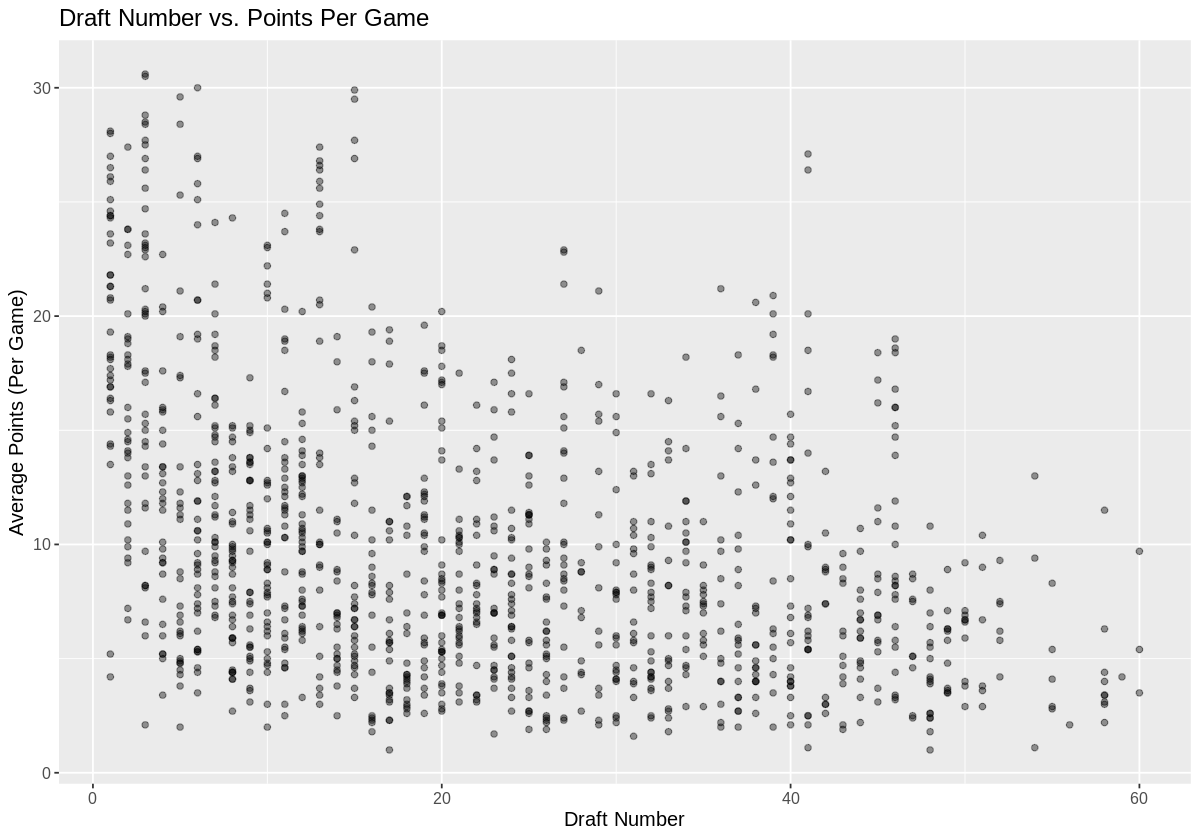

In [ ]:
options(repr.plot.width = 10)

nba_plot_rebounds <- ggplot(nba_training, aes(x = reb, y = pts)) +
geom_point(alpha = 0.4) +
labs(x = "Average Rebounds (Per Game)", y = "Average Points (Per Game)") +
ggtitle("Rebound vs. Points Per Game") +
theme(text = element_text(size = 12))

nba_plot_assists <- ggplot(nba_training, aes(x = ast, y = pts)) +
geom_point(alpha = 0.4)+
labs(x = "Average Assist (Per Game)", y = "Average Points (Per Game)") +
ggtitle("Assist vs. Points Per Game") +
theme(text = element_text(size = 12))

nba_plot_usage_pct <- ggplot(nba_training, aes(x = usg_pct, y = pts)) +
geom_point(alpha = 0.4) +
labs(x = "Average Usage (Percentage)", y = "Average Points (Per Game)") +
ggtitle("Usage Percentage vs. Points Per Game") +
theme(text = element_text(size = 12))

nba_plot_true_shooting_pct <- ggplot(nba_training, aes(x = ts_pct, y = pts)) +
geom_point(alpha = 0.4) +
labs(x = "Average True Shooting Efficiency (Percentage)", y = "Average Points (Per Game)") +
ggtitle("True Shooting Efficiency Percentage vs. Points Per Game") +
theme(text = element_text(size = 12))

nba_plot_number <- ggplot(nba_training, aes(x = draft_number, y = pts)) +
geom_point(alpha = 0.4) +
labs(x = "Draft Number", y = "Average Points (Per Game)") +
ggtitle("Draft Number vs. Points Per Game") +
theme(text = element_text(size = 12))

nba_plot_rebounds
nba_plot_assists
nba_plot_usage_pct
nba_plot_true_shooting_pct
nba_plot_number

As shown in the visualizations above, usage percentage appears to have strong and somewhat linear relationship with points scored, which makes it potentially a good predictor. The other variables also exhibit trends, with rebounds and exhists showing a positive relationship with points scored. Draft number seems to have a weak negative relationship, and true shooting percentage shows a distribution with the area with the highest points surrounding the centre of the graph. The lack of linearity with several of the variables supports the use of k-nearest neighbors for this data set over linear regression.

Shown below is the calculated means of the variables, as well as the total number of data points within the training set.

In [22]:
summarise_rebounds <- summarise(nba_training, mean_rebounds = mean(reb))
summarise_assists <- summarise(nba_training, mean_assists = mean(ast))
summarise_usage_pct <- summarise(nba_training, mean_usage = mean(usg_pct))
summarise_true_shooting_pct <- summarise(nba_training, mean_ts = mean(ts_pct))
summarise_draft_number <- nba_training |>
summarise(mean_number = mean(as.numeric(draft_number), na.rm = TRUE))
summarise_nrow <- summarise(nba_training, total_rows = nrow(nba_training))

combined_summary <- bind_cols(summarise_rebounds, summarise_assists, summarise_usage_pct,
summarise_true_shooting_pct, summarise_draft_number, summarise_nrow)


combined_summary

mean_rebounds,mean_assists,mean_usage,mean_ts,mean_number,total_rows
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
4.078998,2.090851,0.1870581,0.5459133,22.01591,1257


## Data Analysis

To predict the player performance variable, we will be using k-nearest neighbors regression, as the relationships between the predictor variables and our performance variable are not all linear, and the performance variable is numeric.

First, we prepare the recipe, using rebounds, assists, usage percentage, true shooting percentage, and draft number to predict the points scored. These variables are all scaled before continuing.

In [23]:
nba_recipe <- recipe(pts ~ reb + ast + usg_pct + ts_pct + draft_number, data = nba_training) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

nba_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 5



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



Then, we prepare the model. First, we will using tuning to determine the best number of neighbours to use, employing 5-fold cross-validation.

In [24]:
nba_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("regression")

nba_vfold <- vfold_cv(nba_training, v = 5, strata = pts)

nba_workflow <- workflow() |>
add_recipe(nba_recipe) |>
add_model(nba_spec)

nba_workflow


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


We want to first determine a general range that the best number of neighbors will lie in, so we begin at 1 and step up to 100 in increments of 5.

In [25]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

nba_results <- nba_workflow |>
  tune_grid(resamples = nba_vfold, grid = k_vals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

nba_results



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,2.547777,5,0.01515145,Preprocessor1_Model01
6,rmse,standard,2.014873,5,0.05545703,Preprocessor1_Model02
11,rmse,standard,2.035289,5,0.05940335,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
86,rmse,standard,2.592424,5,0.07191745,Preprocessor1_Model18
91,rmse,standard,2.622516,5,0.07567529,Preprocessor1_Model19
96,rmse,standard,2.647718,5,0.07778988,Preprocessor1_Model20


Then, we can select the number of neighbors from this list with the best predicted accuracy. Also shown is a graph of the number of neighbours vs. the mean RMSE.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,rmse,standard,2.014873,5,0.05545703,Preprocessor1_Model02


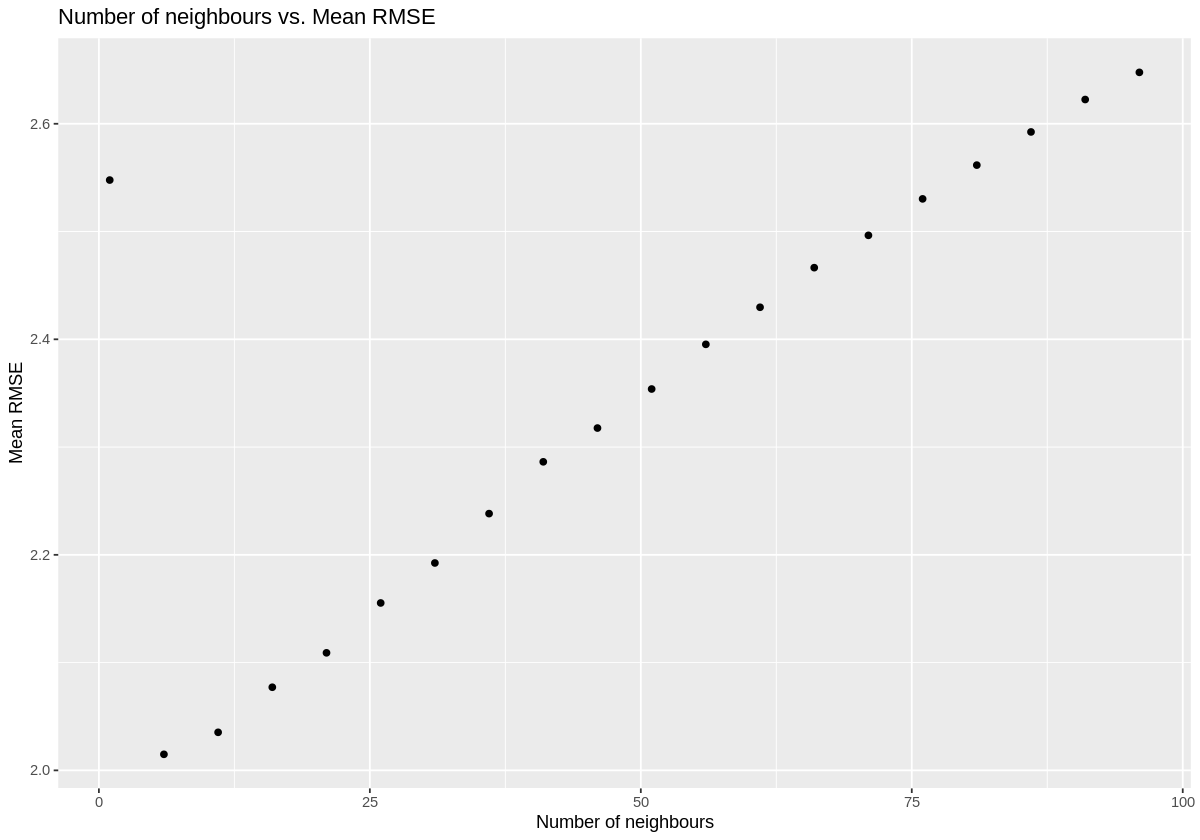

In [26]:
nba_k_plot <- ggplot(nba_results, aes(x = neighbors, y = mean)) +
geom_point() +
labs(x = "Number of neighbours", y = "Mean RMSE") +
ggtitle("Number of neighbours vs. Mean RMSE")

nba_k_plot

nba_k_initial <- nba_results |>
  filter(mean == min(mean))
nba_k_initial

To determine the single best value, we narrow down the range of neighbors we investigate to be between 1 and 15, and step by 1 to find the best value.

In [27]:
k_vals_narrow <- tibble(neighbors = seq(from = 1, to = 15, by = 1))

nba_results_2 <- nba_workflow |>
  tune_grid(resamples = nba_vfold, grid = k_vals_narrow) |>
  collect_metrics() |>
  filter(.metric == "rmse")

nba_results_2

nba_smallest <- nba_results_2 |>
  filter(mean == min(mean))
nba_smallest


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,2.547777,5,0.01515145,Preprocessor1_Model01
2,rmse,standard,2.287345,5,0.03319824,Preprocessor1_Model02
3,rmse,standard,2.181214,5,0.03566900,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,rmse,standard,2.035306,5,0.06045959,Preprocessor1_Model13
14,rmse,standard,2.052483,5,0.06125646,Preprocessor1_Model14
15,rmse,standard,2.058973,5,0.06871147,Preprocessor1_Model15


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
8,rmse,standard,1.99752,5,0.07020462,Preprocessor1_Model08


Next, we prepare the final model, using the optimal amount of neighbors.

In [28]:
neighbors_val <- nba_smallest |>
pull(neighbors)

nba_tuned_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = neighbors_val) |>
  set_engine("kknn") |>
  set_mode("regression")

nba_fit <- workflow() |>
  add_recipe(nba_recipe) |>
  add_model(nba_tuned_spec) |>
  fit(data = nba_training)

nba_predict <- nba_fit |>
  predict(nba_testing) |>
  bind_cols(nba_testing)

nba_rmse <- nba_predict |>
  metrics(truth = pts, estimate = .pred) |>
  filter(.metric == 'rmse')

nba_predict_select <- nba_predict |>
select(.pred, pts)

nba_predict_select

nba_rmse

.pred,pts
<dbl>,<dbl>
4.2125,2.3
2.7500,1.3
6.9750,4.8
⋮,⋮
10.9125,11.9
12.2250,11.3
13.2000,12.1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.93851


The final RMSPE for our model against the testing data is 1.938. While this is still a significant amount of error, in the context of predicting sports performance, the predictions offered by our model are still useful. Visualization of the completed model's performance is difficult owing to the numerous variables involved. Below, each variable used to predict player score is depicted separately.

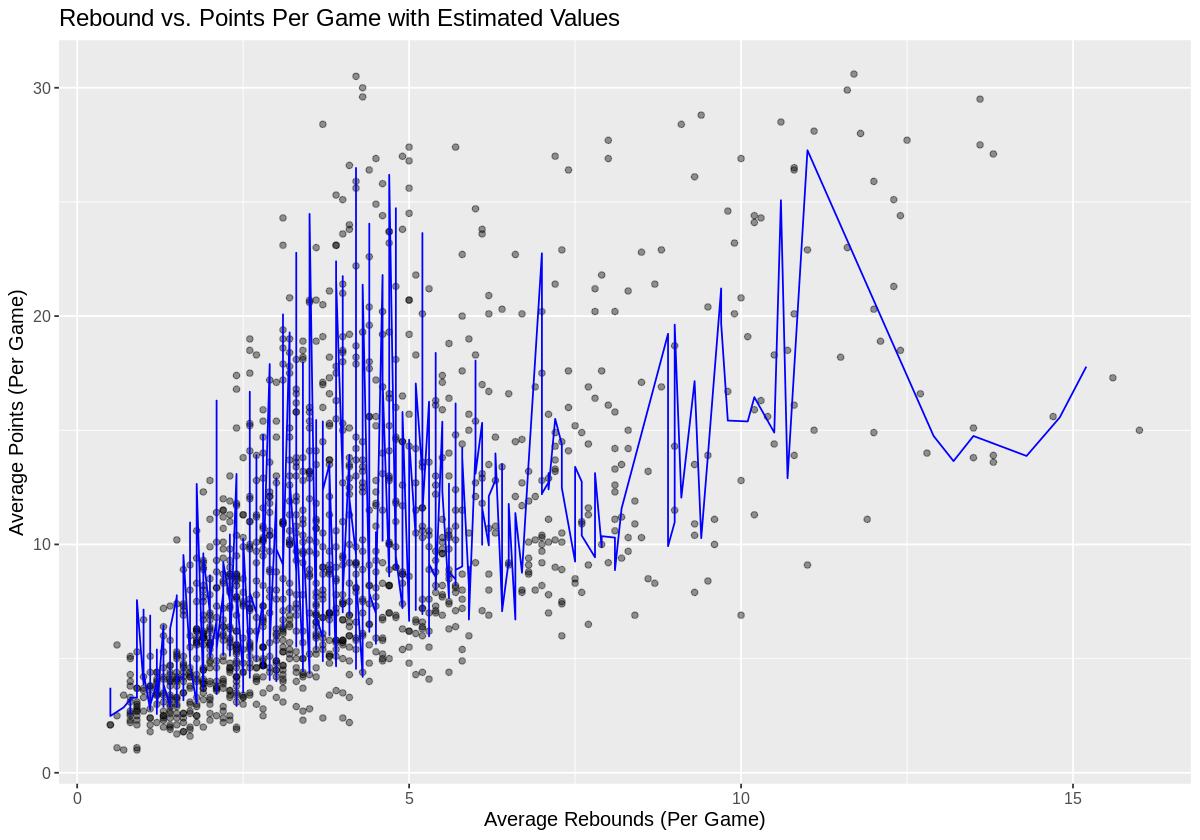

In [45]:
options(repr.plot.width = 10)
nba_predict_plot_rebound <- ggplot(nba_training, aes(x = reb, y = pts)) +
geom_point(alpha = 0.4) +
geom_line(data = nba_predict, mapping = aes(x = reb, y = .pred), color = 'blue') +
labs(x = "Average Rebounds (Per Game)", y = "Average Points (Per Game)") +
ggtitle("Rebound vs. Points Per Game with Estimated Values") +
theme(text = element_text(size = 12))

nba_predict_plot_rebound

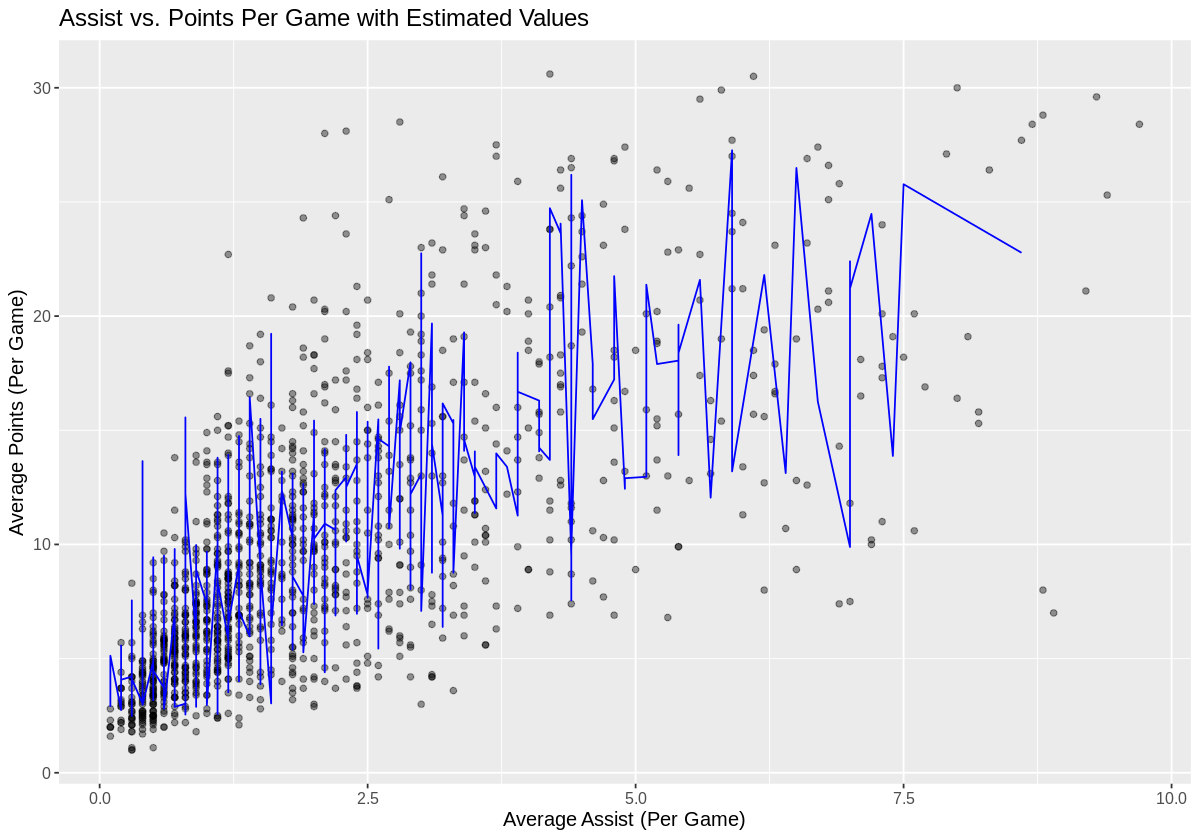

In [46]:
nba_predict_plot_assist <- ggplot(nba_training, aes(x = ast, y = pts)) +
geom_point(alpha = 0.4) +
geom_line(data = nba_predict, mapping = aes(x = ast, y = .pred), color = 'blue') +
labs(x = "Average Assist (Per Game)", y = "Average Points (Per Game)") +
ggtitle("Assist vs. Points Per Game with Estimated Values") +
theme(text = element_text(size = 12))

nba_predict_plot_assist

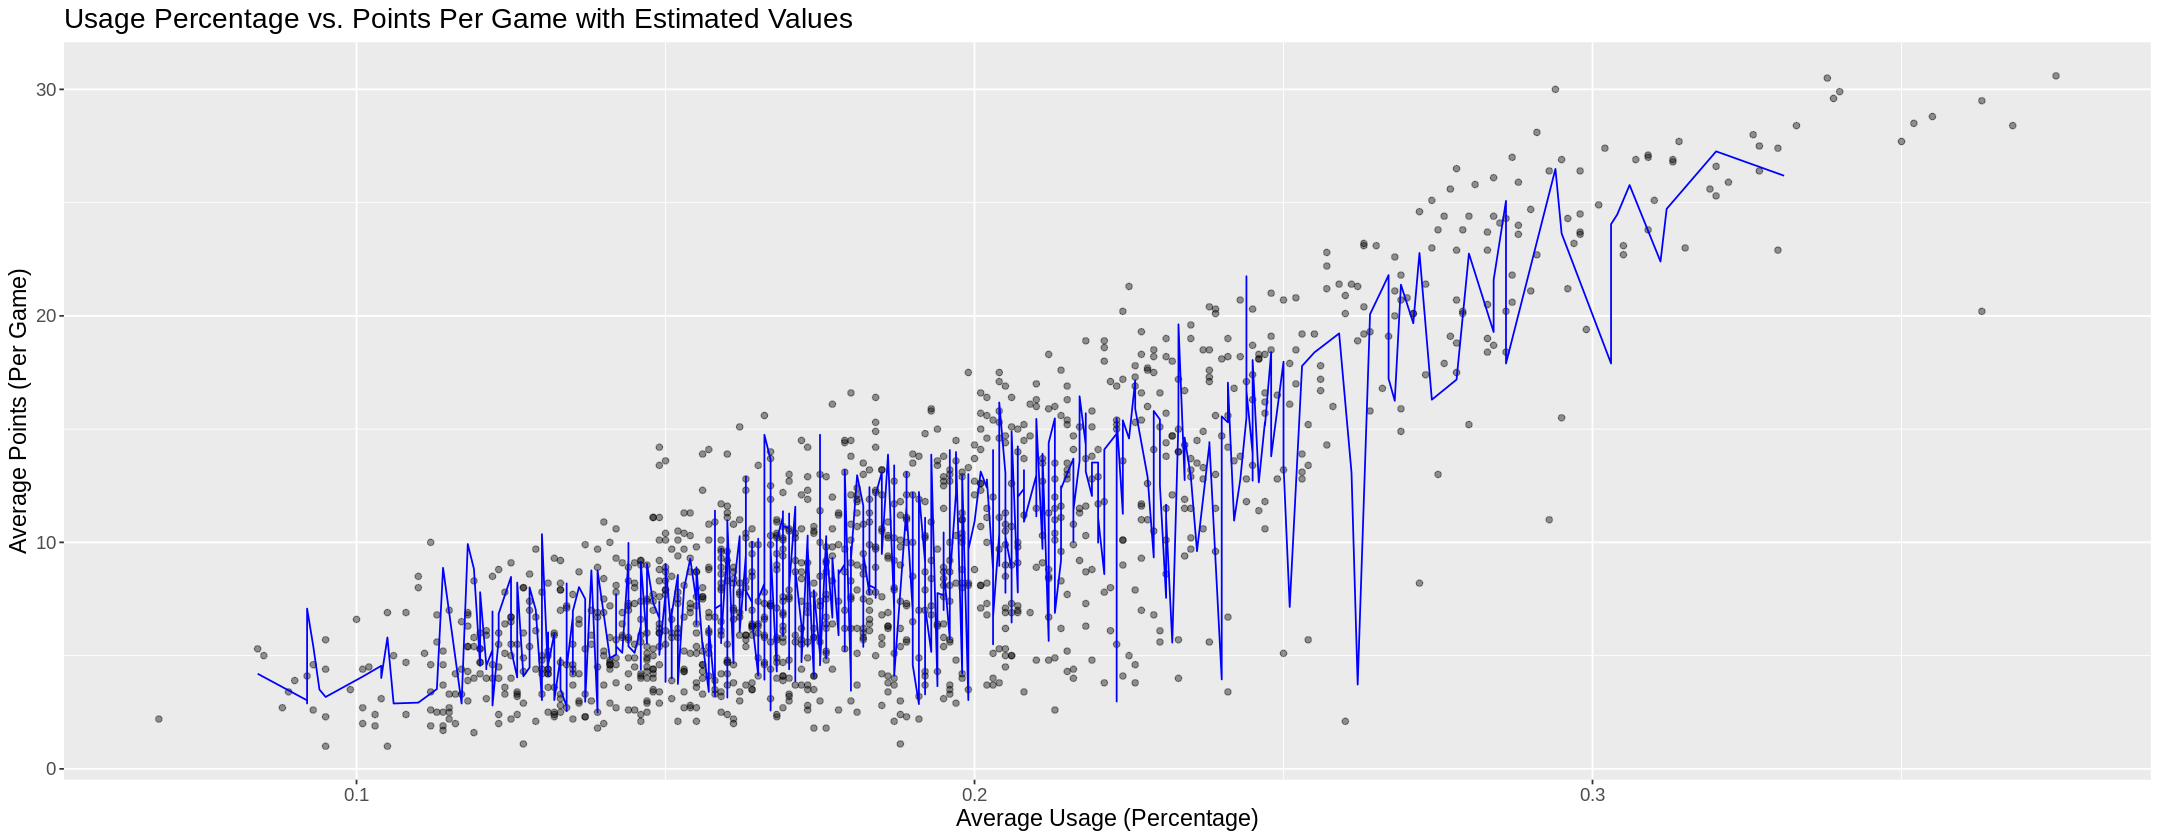

In [47]:
options(repr.plot.width = 18)

nba_predict_plot_usage <- ggplot(nba_training, aes(x = usg_pct, y = pts)) +
geom_point(alpha = 0.4) +
geom_line(data = nba_predict, mapping = aes(x = usg_pct, y = .pred), color = 'blue') +
labs(x = "Average Usage (Percentage)", y = "Average Points (Per Game)") +
ggtitle("Usage Percentage vs. Points Per Game with Estimated Values") +
theme(text = element_text(size = 14))

nba_predict_plot_usage

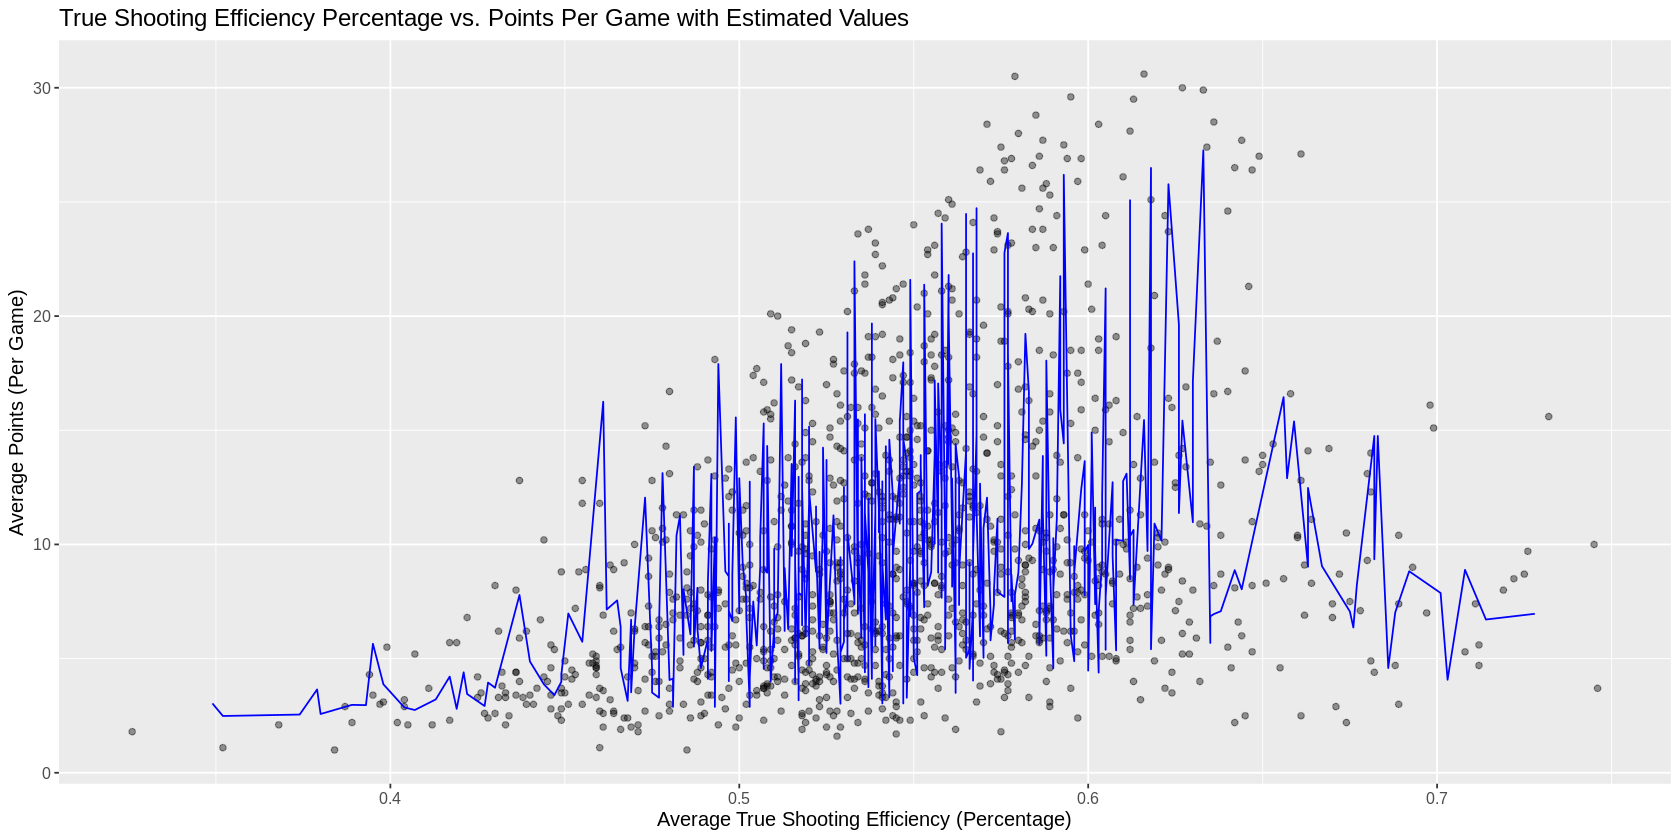

In [48]:
options(repr.plot.width = 14)

nba_predict_plot_shooting <- ggplot(nba_training, aes(x = ts_pct, y = pts)) +
geom_point(alpha = 0.4) +
geom_line(data = nba_predict, mapping = aes(x = ts_pct, y = .pred), color = 'blue') +
labs(x = "Average True Shooting Efficiency (Percentage)", y = "Average Points (Per Game)") +
ggtitle("True Shooting Efficiency Percentage vs. Points Per Game with Estimated Values") +
theme(text = element_text(size = 12))

nba_predict_plot_shooting

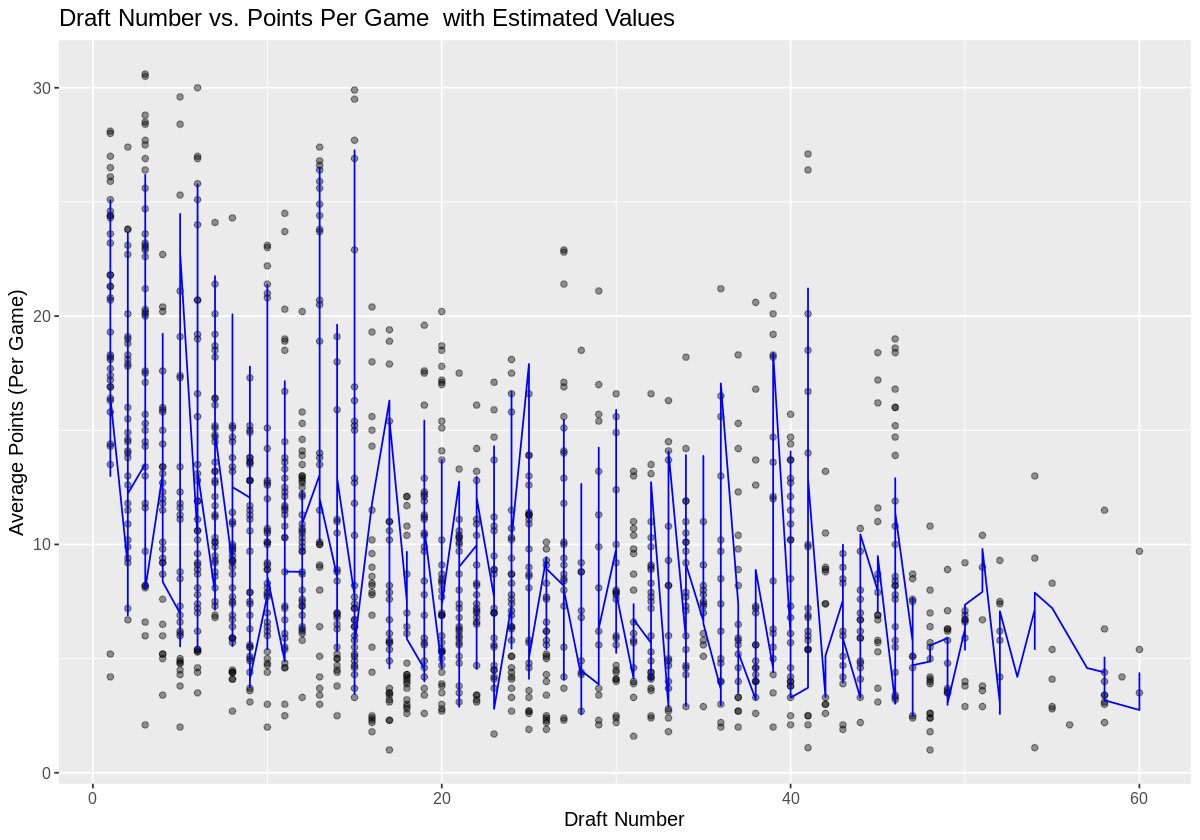

In [49]:
options(repr.plot.width = 10)
nba_predict_plot_dn <- ggplot(nba_training, aes(x = draft_number, y = pts)) +
geom_point(alpha = 0.4) +
geom_line(data = nba_predict, mapping = aes(x = draft_number, y = .pred), color = 'blue') +
labs(x = "Draft Number", y = "Average Points (Per Game)") +
ggtitle("Draft Number vs. Points Per Game  with Estimated Values") +
theme(text = element_text(size = 12))

nba_predict_plot_dn

Observe that the visualizations indicate that the data has been overplotted, with the model being heavily affected by each individual data point. Originally we attributed this to the low number of neighbors (9) relative to the data size, however, this behaviour is still present even when increasing neighbors, as illustrated by the orange demo plot. 

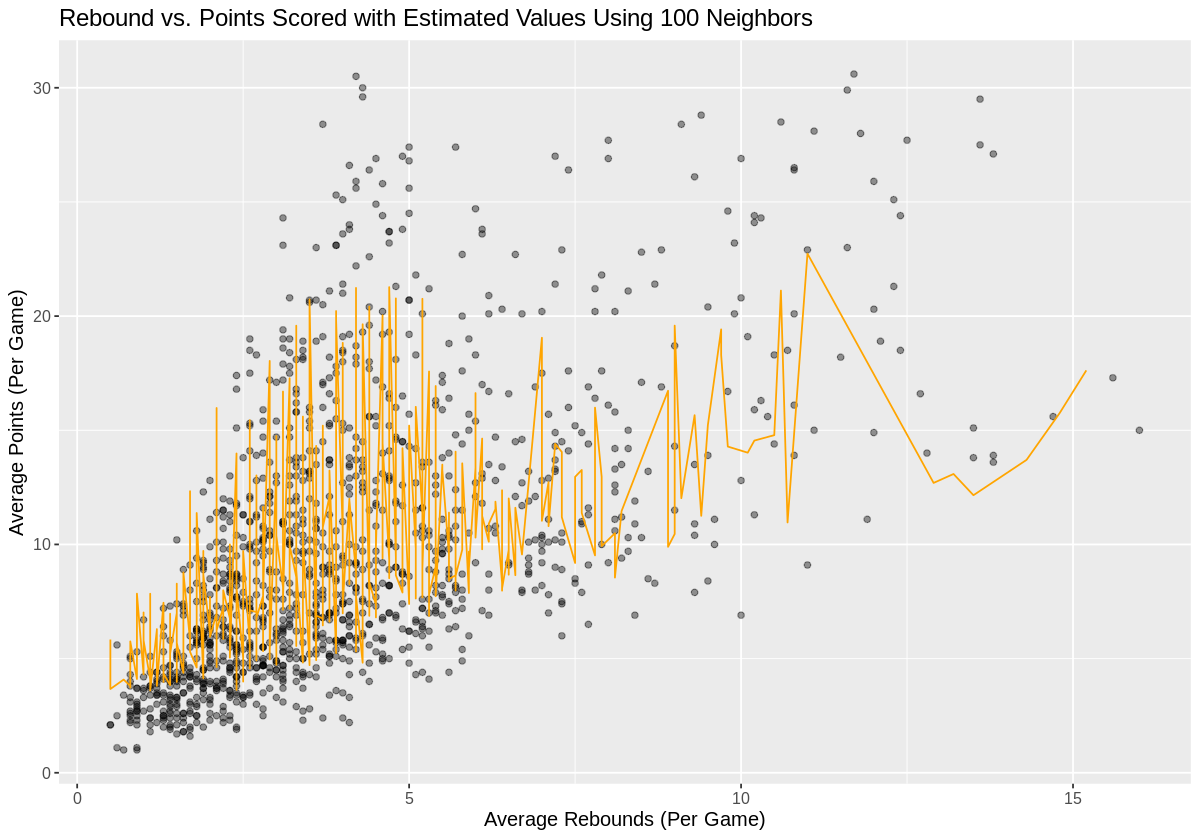

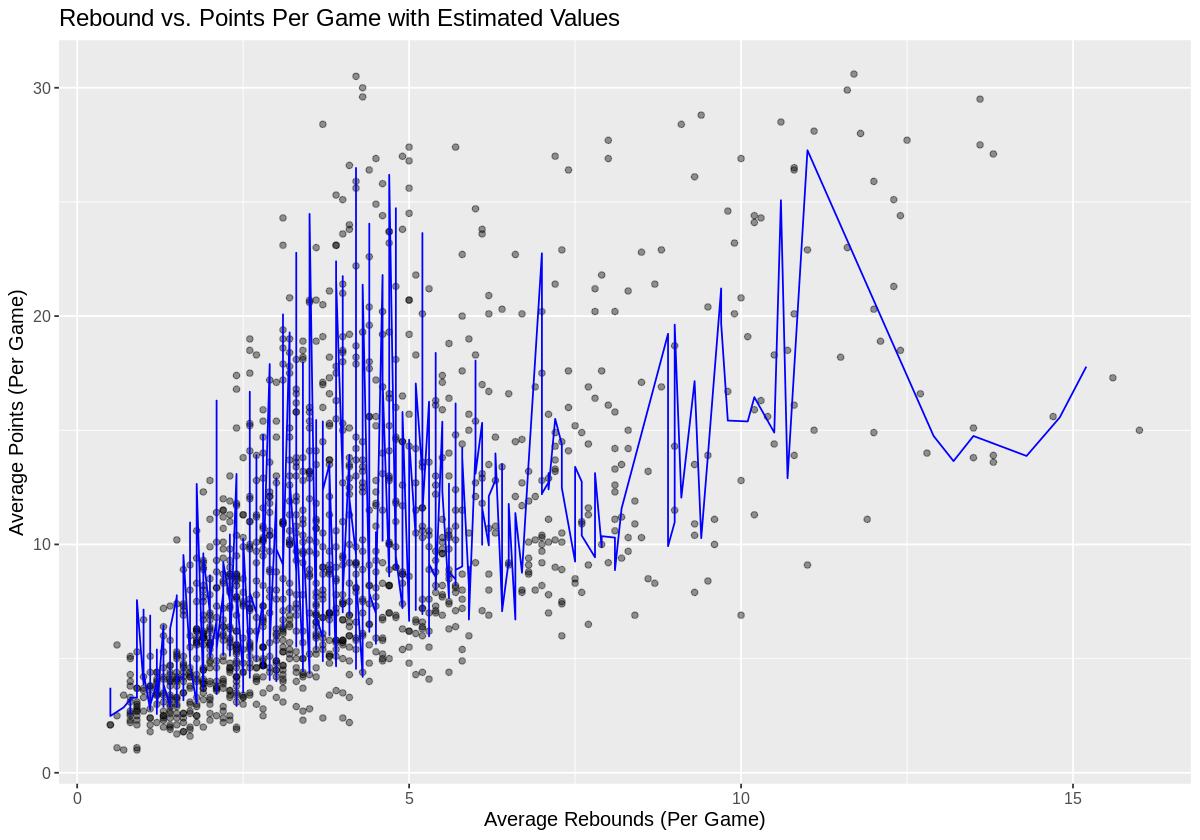

In [50]:
nba_demo_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 100) |>
  set_engine("kknn") |>
  set_mode("regression")

nba_fit_demo <- workflow() |>
  add_recipe(nba_recipe) |>
  add_model(nba_demo_spec) |>
  fit(data = nba_training)

nba_predict_demo <- nba_fit_demo |>
  predict(nba_testing) |>
  bind_cols(nba_testing)

nba_predict_demo_plot <- ggplot(nba_training, aes(x = reb, y = pts)) +
geom_point(alpha = 0.4) +
geom_line(data = nba_predict_demo, mapping = aes(x = reb, y = .pred), color = 'orange') +
labs(x = "Average Rebounds (Per Game)", y = "Average Points (Per Game)") +
ggtitle("Rebound vs. Points Scored with Estimated Values Using 100 Neighbors") +
theme(text = element_text(size = 12))


nba_predict_demo_plot
nba_predict_plot_rebound

# Discussion

Through this analysis, we determined that by using certain measurements of player performance, we were able provide reasonable estimates for the player’s average points per game. The final model had an RMSPE of 1.9 with our testing set. Though this is still a significant amount of error, we think that the predictions offered by this model could still be useful for general predictive needs. 

Our model could particularly benefit by a few changes to our data set, basketball is a team sport played with positions, if each player were to be categorized as by thier position and outliers in our data caused by playing style (low rebound high scoring guards or low scoring high true shooting efficiency centers), it could provide much greater insight into predictions per player.

Although we had expected that these variables to have some capability in predicting point performance, the accuracy of the predictions was somewhat unexpected, yet we have been able to answer our initial question of how our variables predict points per game. It is actually True shooting and Usage percentages that best provide a prediction as to points per game scored. This can be explained by the nature of basketball itself, as higher efficiency when shooting would incentivise more shooting and generate more points per shot while higher usage percentages leading to more scoring can be attributed to better players simply having the ball more than others.

* summarize what you found
* discuss whether this is what you expected to find?
* discuss what impact could such findings have?
* discuss what future questions could this lead to?

# References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.